### Note:

This is **the third version** of the final project. Below is the list of modifications I made from the second version.

- Included graphs showing the scores of each K value for **SelectKBest**.
- In **the second version**, due to the randomness, I decided not to use the **feature importances** in **Decision Tree** when selecting the best features. In this version, I used this method to remove lowest one at a time iteratively.
- Enhanced the performance by using **cv** parameter in **GridSearchCV**.
- Used **Pipeline** to rescale the data set more easily.
- Used **KNeighborClassifier** instead of **KNeighborRegressor**.
- Only used **Decision Tree** and **KNN** for the classifiers. Excluded **GaussianNB**, **SVM** and **Logistic Regression**.
- Included the importance of **parameter tuning** in the **Final Thoughts**.

# Identifying POI from Enron Dataset
### Final Project - Machine Learning Course
### Udacity Data Analyst Nanodegree

This is the final project for the machine learning course. Enron financial data and email data will be investigated to find the list of person of interest (POI) who were involved in the fraud activities.

Below is the order of the investigation process I will employ for this final project.
- Univariate analysis
    - Process the dataset (taking care of missing values and outliers)
    - Select good features that don't have too many zeros or missing values
    - Calculate accuracy, precision and recall for each feature I selected using classifiers with default parameters.
- Bivariate analysis 
    - Use features that show the high scores from the univariate analysis
    - Calculate accuracy, precision and recall from a pair of features using more classifiers and various parameters.
- Multivariate analysis
    - Calculate accuracy, precision and recall from features with the best scores from univariate and bivariate analysis.

In the end, I will choose the combination of features and classifier that shows the best scores.

First, necessary Libraries will be loaded.

In [2]:
#!/usr/bin/python

import sys
import pickle
import pprint
import matplotlib.pyplot as plt
import numpy as np

### Setting the path
sys.path.append("../tools/")

### These are the scripts given in the class
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Load the dictionary containing the dataset.

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
len(data_dict)

146

There are total 146 number of data in data_dict. I am going to print out the first two of the data from data_dict to see how the dictionary looks like.

In [5]:
stop = 0
for k, v in data_dict.iteritems():
    print k
    pprint.pprint(v)
    if stop == 1:
        break
    stop += 1

METTS MARK
{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}
BAXTER JOHN C
{'bonus': 1200000,
 'deferral_payments': 1295738,
 'deferred_income': -1386055,
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 6680544,
 'expenses': 11200,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 1586055,
 'other': 2660303,
 'poi': False,
 'restricted_stock': 3942714,
 'rest

The keys of data_dict are the names of people and the values are various features. Every feature except poi and email_address are numerical values. It looks like it is either a number of 'NaN' when the data is missing. And poi is a boolean value that I can use to find POI's.

In [6]:
### Finding the number of features
for k,v in data_dict.iteritems():
    print "The number of features:", len(v)
    features_list = v.keys() # features are saved separately for later use
    
    ### Save the raw features
    total_features_list = v.keys()
    break

The number of features: 21


There are total 21 features in the dataset. I will ignore "email_address" because they are not numerical values. And I will ingore 'other' as well because I don't know what this is.

In [7]:
### Removing poi and email_address
try:
    features_list.remove("email_address")
    features_list.remove("other")
except:
    pass
try:
    total_features_list.remove("email_address")
    total_features_list.remove("other")
except:
    pass

### Convert data_dict into numpy array
data = featureFormat(data_dict, features_list)
print "The type of data:", type(data)
print "The total number of data", data.shape

The type of data: <type 'numpy.ndarray'>
The total number of data (145L, 19L)


Now the data_dict is converted to numpy array. And it contains 145 rows and 19 columns. 
featureFormat ignores the "NaN" values and creates numpy array that I can use it for the analysis more easily.

Using data numpy array I will check the number of poi's and non-poi's.

In [8]:
### Finding the index of poi
poi_ind = features_list.index("poi")

### Print out the number of poi and non-poi
print "The total number of poi:", np.sum(data[:,poi_ind])
print "The total number of non-poi:", np.size(data[:,poi_ind]) - np.sum(data[:,poi_ind])

The total number of poi: 18.0
The total number of non-poi: 127.0


There are total **18 POI** and **127 non-POI.

In [9]:
### Move poi column to the end
### data
tmp_data = data
tmp_data[:,-1] = data[:,poi_ind]
tmp_data[:,poi_ind] = data[:,-1]
data = tmp_data

### features_list
tmp = features_list[-1]
features_list[poi_ind] = tmp
features_list[-1] = "poi"

### Reassign poi index
poi_ind = features_list.index("poi")

I moved poi column to the end to use the data more easily.

## Plotting

From now on, I will start drawing various plots for univariate analysis and bivariate analysis.
I will draw histograms for each feature first.

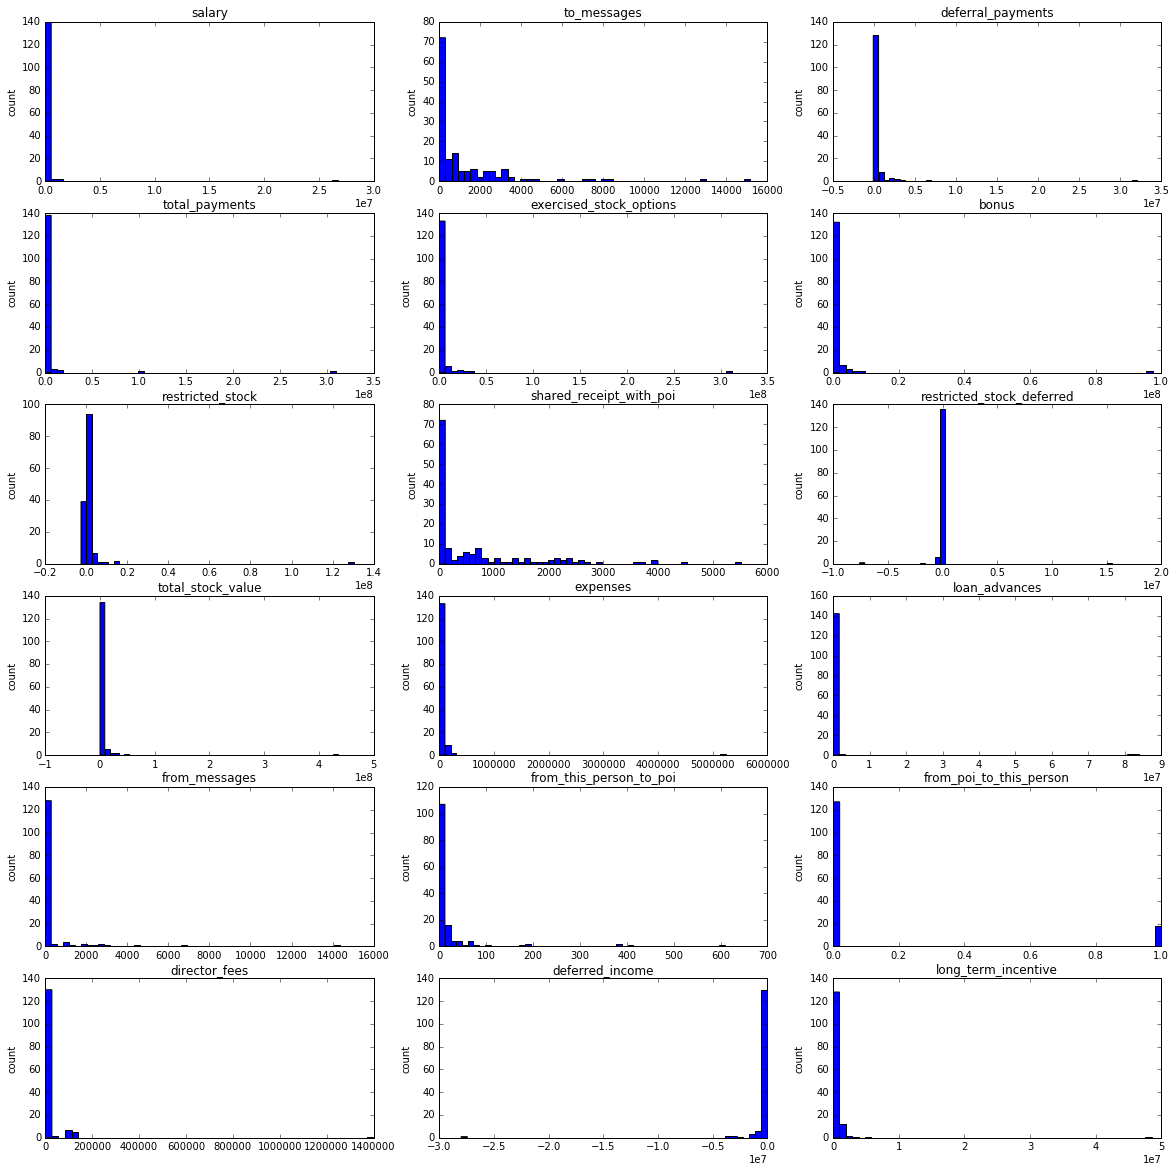

In [10]:
### Create new features list without poi
features_list_new = [ii for ii in features_list if ii != "poi"]

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

Above diagrams show 19 histograms. I first created new list of features excluding poi because array of poi consists of only true or false so it won't provide an insightful histogram. 

Looking at these histograms, I can see there are outliers for every feature.

I will look into salary more deeply and see if there is any interesting thing going on.

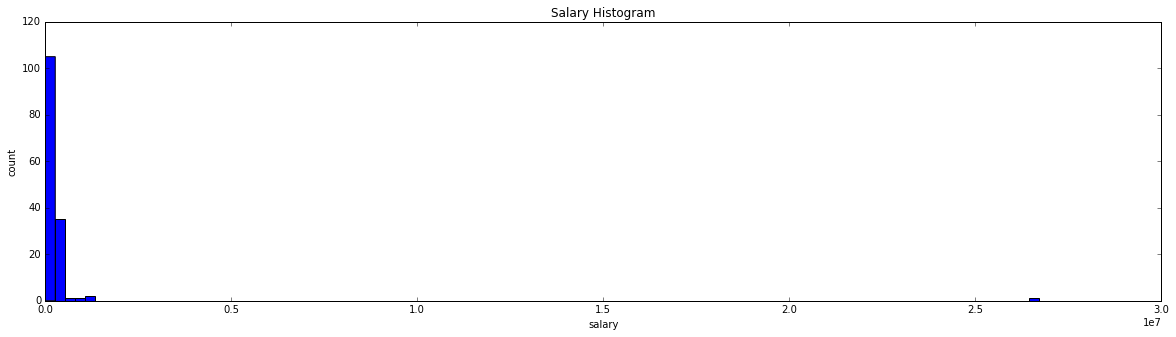

In [11]:
%matplotlib inline
### Find indices for salary
salary_ind = features_list.index("salary")

### Set the size of the plot
plt.rcParams["figure.figsize"] = (20,5)

### Draw Salary histogram
plt.hist(data[:,salary_ind], bins=100)
plt.xlabel("salary")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

Now I will get rid of the outlier above 2.5e7 and replot the histogram

53408458.0 is the total sum of salaries
26704229.0 is removed


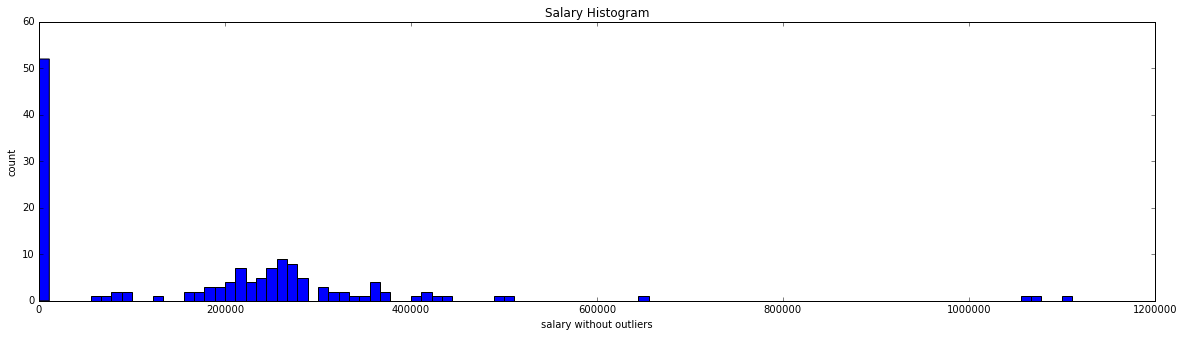

In [12]:
### Total sum of salaries
import numpy as np
print np.sum(data[:,salary_ind]), "is the total sum of salaries"

### Create new array that contains salar values without outliers
salary_no_outliers = []
for i in data[:,salary_ind]:
    if i < 2.5e7:
        salary_no_outliers.append(i)
    else:
        print i, "is removed"

### Draw Salary histogram
plt.hist(salary_no_outliers, bins=100)
plt.xlabel("salary without outliers")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

The outlier removed is half of the total sum of salary array, which means someone added a total sum of salaries into the data. I believe that in data_dict there is a key that contains the sum of every feature.

In [13]:
for k,v in data_dict.iteritems():
    if v["salary"] == 26704229.0:
        print k,v

TOTAL {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


As I expected one of the keys in data_dict is TOTAL. I will create a new dictionary that excludes this key.

In [14]:
### New data_dict excluding TOTAL key
data_dict_new = {}

for k, v in data_dict.iteritems():
    if k != "TOTAL":
        data_dict_new[k] = v

### Print out the new data_dict length
print "The length of the new data_dict:", len(data_dict_new)
    

The length of the new data_dict: 145


Now there are 145 data in the data_dict_new. I will graph the histograms again.

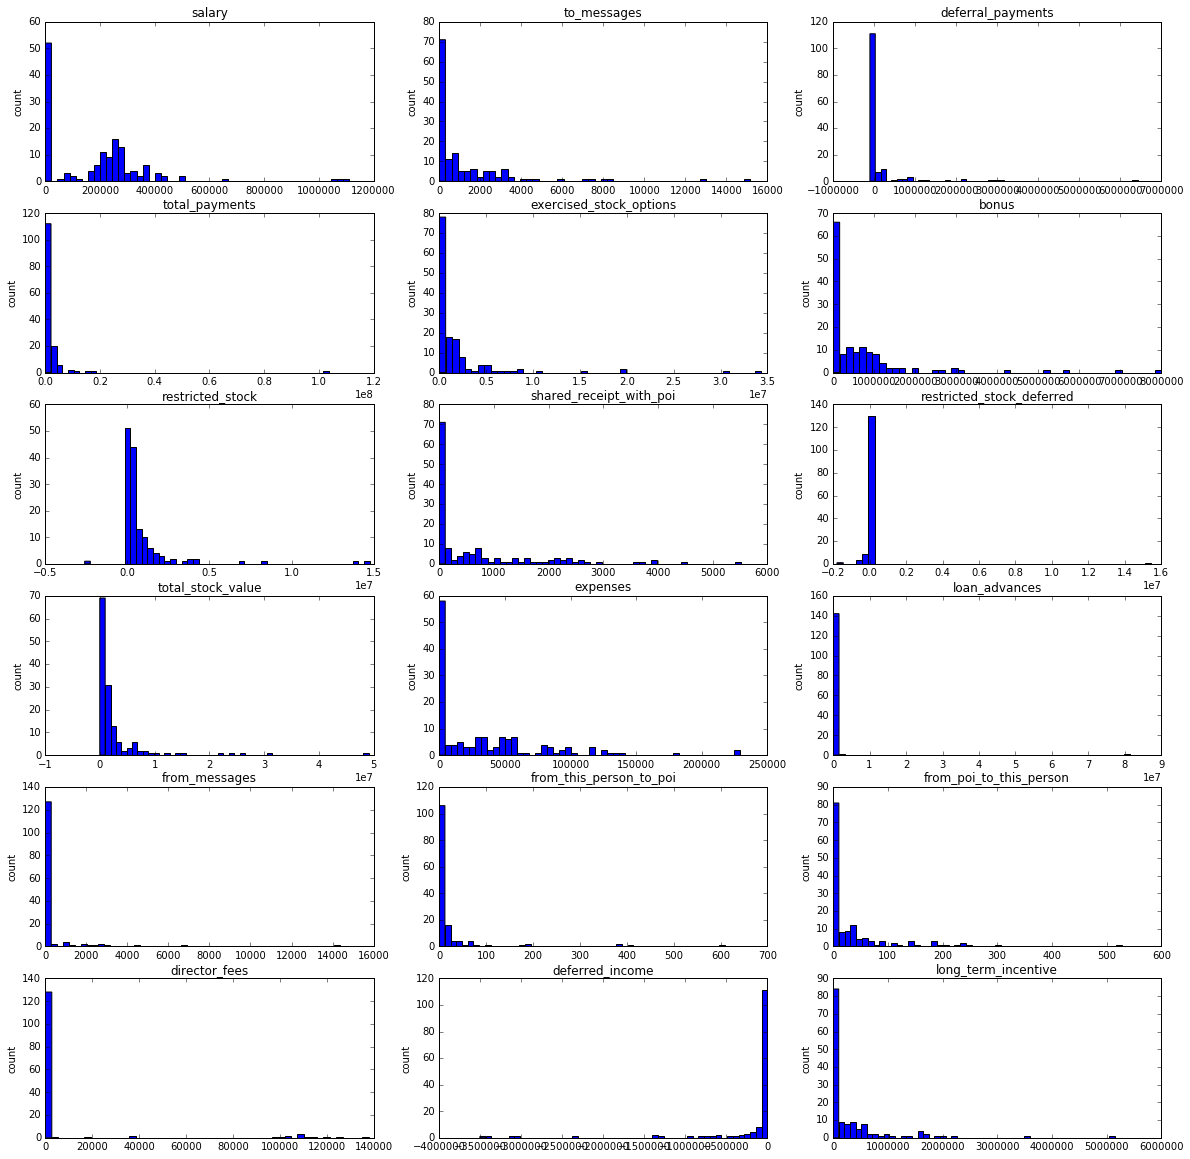

In [15]:
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

The histograms are better than before. Although there are still outliers in histograms, getting rid of them might not be a good idea because those values may be helpful identifying POI's.

I suspect that some of these features will have too many zeros because featureFormat function convert NaN to zero in some cases. I will print out the number of zeros for each feature. 

In [16]:
### defining function that counts zeros
def counting_zeros(data, features_list, feature):
    total_count = 0
    count = 0
    feature_data = data[:,features_list.index(feature)]
    for i in feature_data:
        total_count += 1
        if i == 0:
            count += 1
    print "{}: {}, {}%".format(feature,count, int(float(count)*100/float(total_count)))

### Printing out the number of zeros for each feature
for i in features_list[:-1]:
    counting_zeros(data, features_list, i)

salary: 50, 34%
to_messages: 58, 40%
deferral_payments: 106, 73%
total_payments: 20, 13%
exercised_stock_options: 43, 29%
bonus: 63, 43%
restricted_stock: 35, 24%
shared_receipt_with_poi: 58, 40%
restricted_stock_deferred: 127, 88%
total_stock_value: 19, 13%
expenses: 50, 34%
loan_advances: 141, 97%
from_messages: 58, 40%
from_this_person_to_poi: 78, 54%
from_poi_to_this_person: 70, 48%
director_fees: 128, 88%
deferred_income: 96, 66%
long_term_incentive: 79, 54%


I will ignore features with more than 60% of zeros from now on.

### Features that will be ignored:
- deferral_payments
- restricted_stock_deferred
- loan_advances
- director_fees
- deferred_income

I will recreate data numpy array and features_list array that exclude the features above.

In [17]:
### Save the original features_list before change
features_list_original = features_list

### list of features with too many zeros
too_many_zeros = ["deferral_payments", 
                  "restricted_stock_deferred",
                  "loan_advances",
                  "director_fees",
                  "deferred_income"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print data.shape

(144L, 14L)


Now the number of columns of data is reduced to 14.

### Checking Scores

Now I am going to test each feature using GaussianNB and check the accuracy, precision and recall. Then I will use features with high values for later use.

I will employ tester functions from tester.

In [18]:
### Import functions from tester_edited.py
from tester_edited import load_classifier_and_data, test_classifier
from sklearn.cross_validation import StratifiedShuffleSplit

This will be a repetitive process so I will create a function to do this.

In [19]:
### the code is from "poi_id.py" from final_project folder.
### this function will split the data into test and train
### apply classifier and calculate the accuracy, precision and recall
def test(features_list, clf, print_result=False, draw_graph=False, rescale=False):
    ### Store to my_dataset for easy export below.
    my_dataset = data_dict
    
    ### Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
#     ### Split train and test by 30 %
#     from sklearn.cross_validation import train_test_split
#     features_train, features_test, labels_train, labels_test = \
#         train_test_split(features, labels, test_size=0.3, random_state=42)
        
    ### Dump the data to the local files
    dump_classifier_and_data(clf, my_dataset, features_list)
    
    ### Load the data from the local files
    clf, dataset, feature_list = load_classifier_and_data()
    
    ### Print out the result
    scores = test_classifier(
        clf, dataset, feature_list, 
        print_result=print_result, draw_graph=draw_graph, rescale=rescale)
    return scores

### import GaussianNB
from sklearn.naive_bayes import GaussianNB

### import Decision Tree
from sklearn import tree

### This function only test the data using
### GaussianNB and Decision Tree
def classify_simple(features_list, print_result=False):
    print "Features list:", features_list[1:]
    
    ### Set GaussianNB
    clf_NB = GaussianNB()

    ### Set Decision Tree
    clf_tree = tree.DecisionTreeClassifier()
    
    ### Call test function and print out test
    scores_NB = test(features_list,clf_NB, print_result=print_result)
    tree_NB = test(features_list,clf_tree, print_result=print_result)
    return [ scores_NB, tree_NB ]

I created a function that can show the accuracy, precision and recall values from features list input. The test function is mainly from the "poi-id.py" file from the final project folder. I creates clf for classifier, features list and dataset so that it can be loaded in test_classifier function in "tester.py" file. Note that the validation used in this code is Train/Test split. The purpose is not to get the largest scores but to select features that show the high scores compared to the others. So I don't use other cross validation for now. For the same reason, I don't specify any parameter for classifiers. The parameters will be adjusted at a later section.

In [20]:
### Always put poi at the zeroth index
classify_simple(["poi", "salary"],print_result=True)

Features list: ['salary']

GaussianNB()

	Best parameters:
	No GridSearch

	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800	F1: 0.30011	F2: 0.47968
	Total predictions: 20000	True positives: 3192	False positives: 14080	False negatives:  808	True negatives: 1920


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

	Best parameters:
	No GridSearch

	Accuracy: 0.69210	Precision: 0.23619	Recall: 0.24150	F1: 0.23881	F2: 0.24042
	Total predictions: 20000	True positives:  966	False positives: 3124	False negatives: 3034	True negatives: 12876



[[0.2556, 0.18480778138026865, 0.798, {}],
 [0.6921, 0.23618581907090463, 0.2415, {}]]

I ran the function using poi and salary. Fortunately the function works.

I will use this function for all the other features.

In [21]:
### Iterate over the features_list
scores_list = {}
for i in features_list[:-1]:
    scores_list[i] = classify_simple(["poi", i])

Features list: ['salary']
Features list: ['to_messages']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['total_payments']
Features list: ['exercised_stock_options']
Features list: ['bonus']
Features list: ['restricted_stock']
Features list: ['shared_receipt_with_poi']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['total_stock_value']
Features list: ['expenses']
Features list: ['from_messages']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['from_this_person_to_poi']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['from_poi_to_this_person']
Features list: ['long_term_incentive']


In [22]:
### Print out scores of each feature
print "      Accuarcy Precision Recall"
for k,v in scores_list.iteritems():
    print k
    if v[0] == None:
        print "NB     ---------None---------"
    else:
        print "NB     {0:.4f}  {1:.4f}  {2:.4f}".format(v[0][0], v[0][1], v[0][2])
    print "tree   {0:.4f}  {1:.4f}  {2:.4f}".format(v[1][0], v[1][1], v[1][2])

      Accuarcy Precision Recall
salary
NB     0.2556  0.1848  0.7980
tree   0.6921  0.2362  0.2415
to_messages
NB     ---------None---------
tree   0.7371  0.0856  0.1410
total_payments
NB     0.7631  0.0694  0.0435
tree   0.7393  0.0804  0.0665
bonus
NB     0.3780  0.2223  0.7200
tree   0.7623  0.4427  0.2685
total_stock_value
NB     0.8406  0.3200  0.0320
tree   0.7584  0.2300  0.2430
shared_receipt_with_poi
NB     ---------None---------
tree   0.8421  0.3020  0.3210
exercised_stock_options
NB     0.8994  0.2108  0.0390
tree   0.8571  0.2686  0.3320
from_messages
NB     ---------None---------
tree   0.7259  0.0067  0.0100
from_this_person_to_poi
NB     ---------None---------
tree   0.7444  0.0218  0.0180
long_term_incentive
NB     0.3980  0.1471  0.6700
tree   0.6943  0.0250  0.0300
expenses
NB     0.3068  0.1885  0.7460
tree   0.6466  0.1295  0.1340
restricted_stock
NB     0.7380  0.1013  0.0560
tree   0.7297  0.1196  0.0765
from_poi_to_this_person
NB     0.7365  0.0263  0.0015
tree

Notice that those features where NB score is zero have zeros more than 50%. Initially I thought removing features with zeros more than 60% might be sufficient but apparently I should have set my threshold to be 60% instead of 50%.

And I will remove total_payments from my list because this feature has precision and recall values less than 1%.

In [23]:
### list of features with too many zeros above 50%
too_many_zeros = ["to_messages",
                  "shared_receipt_with_poi",
                  "from_messages",
                  "from_this_person_to_poi",
                  "total_payments"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print "Shape of data:", data.shape
pprint.pprint(features_list)

Shape of data: (139L, 9L)
['salary',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'long_term_incentive',
 'poi']


The number of columns are reduced to 9 including poi. Let's print the result again only from these features.

In [24]:
### Print out scores of each feature
print "      Accuarcy Precision Recall"
for k,v in scores_list.iteritems():
    if k in features_list:
        print k
        if v[0] == None:
            print "NB     ---------None---------"
        else:
            print "NB     {0:.4f}  {1:.4f}  {2:.4f}".format(v[0][0], v[0][1], v[0][2])
        print "tree   {0:.4f}  {1:.4f}  {2:.4f}".format(v[1][0], v[1][1], v[1][2])

      Accuarcy Precision Recall
salary
NB     0.2556  0.1848  0.7980
tree   0.6921  0.2362  0.2415
bonus
NB     0.3780  0.2223  0.7200
tree   0.7623  0.4427  0.2685
total_stock_value
NB     0.8406  0.3200  0.0320
tree   0.7584  0.2300  0.2430
exercised_stock_options
NB     0.8994  0.2108  0.0390
tree   0.8571  0.2686  0.3320
long_term_incentive
NB     0.3980  0.1471  0.6700
tree   0.6943  0.0250  0.0300
expenses
NB     0.3068  0.1885  0.7460
tree   0.6466  0.1295  0.1340
restricted_stock
NB     0.7380  0.1013  0.0560
tree   0.7297  0.1196  0.0765
from_poi_to_this_person
NB     0.7365  0.0263  0.0015
tree   0.6425  0.1312  0.0765


From the result above, the features with the best scores are **bonus**, **exercised_stock_options** and **total_stock_value**.
I will use these features as my main dependent variables for the bivariate analysis.

## Selecting features using SelectKBest and Decision Tree Features Importance

The above selection is choosing the features with few zeros. However, having many zeros not necessarily means the data is bad. 

In the previous version, I found **14** features with the best scores using **SelectKBest**. And **14** is a number I chose randomly so it doesn't have any significance. In this version, I will find the number that maximize the performance using **SelectKBest**.

In [34]:
### Convert data_dict_new into numpy array
total_data = featureFormat(data_dict_new, total_features_list)

print total_data.shape

### Extract features from the data
features = total_data
features = np.delete(features, total_features_list.index("poi"), 1)

### Extract a label from the data
label = total_data[:,total_features_list.index("poi")]

### Rescale features
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features) 

### Import SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

pre_selected_list = []
features_by_importance = []
for k in range(1,19):
    selector = SelectKBest(f_classif, k=k)
    selector = selector.fit(features,label)

    features_list_wo_poi = [i for i in total_features_list if i!="poi"] ### features list without poi

    ### Print features chosen by SelectKBest
    selected_list = [features_list_wo_poi[i] for i in range(len(features_list_wo_poi)) if selector.get_support()[i]]
    
    print "K:", k
    for i in selected_list:
        if i not in pre_selected_list:
            print "\t", i
            features_by_importance.append(i)
        
    pre_selected_list = selected_list

(144L, 19L)
K: 1
	exercised_stock_options
K: 2
	total_stock_value
K: 3
	bonus
K: 4
	salary
K: 5
	deferred_income
K: 6
	long_term_incentive
K: 7
	restricted_stock
K: 8
	total_payments
K: 9
	shared_receipt_with_poi
K: 10
	loan_advances
K: 11
	expenses
K: 12
	from_poi_to_this_person
K: 13
	from_this_person_to_poi
K: 14
	director_fees
K: 15
	to_messages
K: 16
	deferral_payments
K: 17
	from_messages
K: 18
	restricted_stock_deferred


The above shows the features that are selected by its importance. The best feature is **exercised_stock_option** and the next best feature is **total_stock_value** and so on. Now I will calculate the scores for each **k** value using **Decision Tree**.

In [51]:
### Import Cross Validation
from sklearn.cross_validation import StratifiedShuffleSplit

### Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

### Import DecisionTree Classifier
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_split=5)

### Use pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[('minmaxer', min_max_scaler), ('clf', clf)])

### Set up the print format
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

### Set up the arrays for precision, recall and F1
precision_list = []
recall_list = []
f1_list = []

### Calculate scores for each K value
for i in range(len(features_by_importance)):
    selected_features_list = features_by_importance[:(i+1)]
    selected_features_list.insert(0,'poi')
    selected_data = featureFormat(data_dict_new, selected_features_list)
    
    ### Split the data into labels and features
    labels, features = targetFeatureSplit(selected_data)
    
    cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

            features_test.append( features[jj])
            labels_test.append( labels[jj] )

        
        ### fit the classifier using training set, and test on test set
        pipe.fit(features_train, labels_train)
        try:
            print clf.best_params_
            for k,v in clf.best_params_.iteritems():
                if k in best_params_collector:
                    best_params_collector[k].append(v)
                else:
                    best_params_collector[k] = [v]
        except:
            pass
            
        predictions = pipe.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            ### Assign prediction either 0 or 1
            if prediction < .5:
                prediction = 0
            else:
                prediction = 1

            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        
        print selected_features_list[-1]
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        
    except:
        print "Precision or recall may be undefined due to a lack of true positive predicitons.\n"

exercised_stock_options
	Accuracy: 0.91536	Precision: 0.57650	Recall: 0.26000	F1: 0.35837	F2: 0.29207
total_stock_value
	Accuracy: 0.83185	Precision: 0.40333	Recall: 0.19400	F1: 0.26199	F2: 0.21647
bonus
	Accuracy: 0.84146	Precision: 0.47688	Recall: 0.31450	F1: 0.37903	F2: 0.33748
salary
	Accuracy: 0.82646	Precision: 0.40504	Recall: 0.27300	F1: 0.32616	F2: 0.29204
deferred_income
	Accuracy: 0.82786	Precision: 0.35901	Recall: 0.26100	F1: 0.30226	F2: 0.27607
long_term_incentive
	Accuracy: 0.81764	Precision: 0.32034	Recall: 0.24650	F1: 0.27861	F2: 0.25841
restricted_stock
	Accuracy: 0.82171	Precision: 0.34041	Recall: 0.26450	F1: 0.29769	F2: 0.27685
total_payments
	Accuracy: 0.82587	Precision: 0.31364	Recall: 0.25750	F1: 0.28281	F2: 0.26706
shared_receipt_with_poi
	Accuracy: 0.82433	Precision: 0.31530	Recall: 0.27100	F1: 0.29148	F2: 0.27884
loan_advances
	Accuracy: 0.82547	Precision: 0.31972	Recall: 0.27400	F1: 0.29510	F2: 0.28207
expenses
	Accuracy: 0.82767	Precision: 0.33558	Recall: 0.29

Scores for each **K** value are calculated above. The feature is appended to the list and the scores are calculated one at a time. According to the result, **Recall** is the highest when **K** is 3.

Let's graph the result.

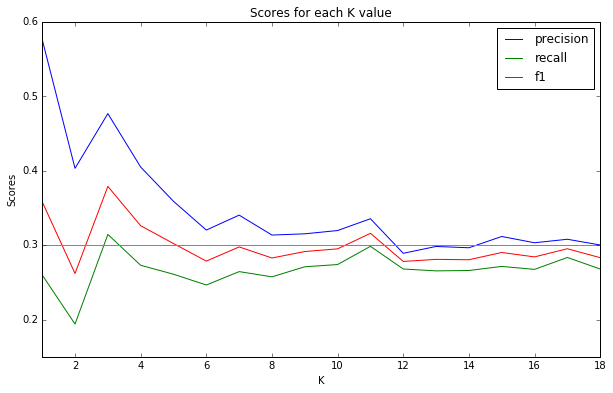

In [63]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (10,6)

### Set up the x-axis
k_values = range(1,len(recall_list)+1)

### Draw Salary histogram
plt.plot(k_values, precision_list, k_values, recall_list, k_values, f1_list)

x = [1,18]
y = [.3,.3]
plt.plot(x,y)

plt.xlim([1,18])

plt.legend(['precision','recall','f1'])
plt.xlabel("K")
plt.ylabel("Scores")
plt.title("Scores for each K value")
plt.show()

The graph above shows the result more visually. First of all the **Precision** is exceptionally high when **K** is 1. However, the **Recall** is the lowest at this point. This means that the model is good picking up the true POIs but it is not good at choosing all of the POIs. For example, if there are 10 POIs then the model chooses 2 or 3 of them correctly but misses other POIs. So it is important to consider **Recall** value as well when evaluating the performance.

I drew a horizontal line at **0.3** because it is the threshold given from the rubric. There is only 1 value of **K** when all of these scores are above **0.3** and that is when **K** is 3.

These are the features selected by **SelectKBest**.

    - exercised_stock_options
    - total_stock_value
    - bonus

Now I will choose the best features using **Feature Importance** in **Decision Tree** algorithm.

Below is the process I will employ to find the best features using **Feature Importance**.

 1. Start from the list containing all of the features.
 2. Calculate the scores with the list using **Decision Tree**.
 3. Calculate **Feature Importance** for each feature in the list.
 4. Drop the feature with the lowest **Importance**.
 5. Go back to **step 2** and repeat the process.

In [171]:
### Use GridSearchCV to find the best parameters
from sklearn.grid_search import GridSearchCV

### Import DecisionTree Classifier
clf = tree.DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'min_samples_split': range(2,9)
      }

### Set up the arrays for precision, recall and F1
precision_list = []
recall_list = []
f1_list = []

if 'poi' not in total_features_list:
    total_features_list.append('poi')
    
selected_features_list = [i for i in total_features_list if i != 'poi']
features_by_importance = []

### Calculate scores for each K value
for i in range(len(total_features_list)-1):
    print 
    
    try:
        print "Dropped Feature:", features_by_importance[-1]
    except:
        pass
    
    selected_features_list_with_poi = ['poi']
    selected_features_list_with_poi.extend(selected_features_list)
    
    selected_data = featureFormat(data_dict_new, selected_features_list_with_poi)
    
    ### Split the data into labels and features
    labels, features = targetFeatureSplit(selected_data)
    
    ### Recale the features
    features = min_max_scaler.fit_transform(features)

    cv = StratifiedShuffleSplit(labels, 100, random_state = 42)
    
    clf_grid = GridSearchCV(clf, param_grid, cv = cv, scoring = 'recall')
    
    clf_grid.fit(features, labels)
    
    print clf_grid.best_params_
    
    clf.set_params(criterion=clf_grid.best_params_["criterion"],
                   splitter=clf_grid.best_params_["splitter"],
                   min_samples_split=clf_grid.best_params_["min_samples_split"])
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

            features_test.append( features[jj])
            labels_test.append( labels[jj] )

        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
         
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            ### Assign prediction either 0 or 1
            if prediction < .5:
                prediction = 0
            else:
                prediction = 1

            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
                
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives)
    recall = 1.0*true_positives/(true_positives+false_negatives)
    f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
    f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)


    print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
    importances = clf.feature_importances_

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    ### Find the index of the feature with the lowest importance
    min_importance = min(importances)
    features_by_importance.append(selected_features_list[np.argmin(importances)])
    selected_features_list.remove(selected_features_list[np.argmin(importances)])
    
    


Dropped Feature: {'min_samples_split': 2, 'splitter': 'random', 'criterion': 'gini'}
	Accuracy: 0.80133	Precision: 0.25743	Recall: 0.26000	F1: 0.25871	F2: 0.25948

Dropped Feature: deferral_payments
{'min_samples_split': 5, 'splitter': 'random', 'criterion': 'gini'}
	Accuracy: 0.81867	Precision: 0.28571	Recall: 0.24000	F1: 0.26087	F2: 0.24793

Dropped Feature: salary
{'min_samples_split': 2, 'splitter': 'random', 'criterion': 'gini'}
	Accuracy: 0.81533	Precision: 0.30052	Recall: 0.29000	F1: 0.29517	F2: 0.29204

Dropped Feature: restricted_stock_deferred
{'min_samples_split': 7, 'splitter': 'random', 'criterion': 'entropy'}
	Accuracy: 0.83667	Precision: 0.35294	Recall: 0.27000	F1: 0.30595	F2: 0.28332

Dropped Feature: total_payments
{'min_samples_split': 2, 'splitter': 'random', 'criterion': 'gini'}
	Accuracy: 0.80533	Precision: 0.27885	Recall: 0.29000	F1: 0.28431	F2: 0.28770

Dropped Feature: to_messages
{'min_samples_split': 4, 'splitter': 'random', 'criterion': 'entropy'}
	Accuracy:

Let's graph the scores to look at the result more visually.

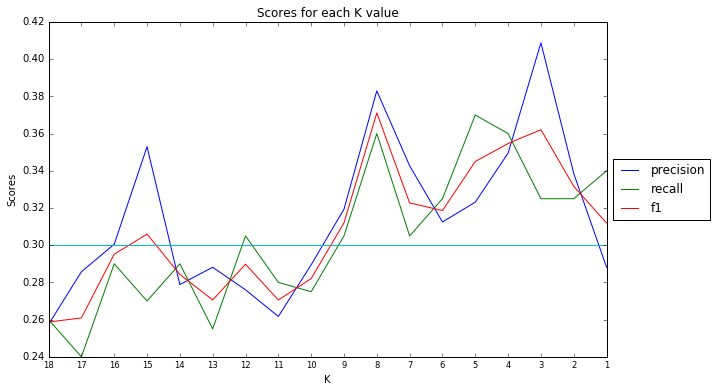

In [175]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (10,6)

### Set up the x-axis
k_values = range(1,len(recall_list)+1)

### Draw Salary histogram
plt.plot(k_values, precision_list, k_values, recall_list, k_values, f1_list)

x = [1,18]
y = [.3,.3]
plt.plot(x,y)

plt.xlim([1,18])

plt.legend(['precision','recall','f1'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(k_values,['18','17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1'], size='small')
plt.xlabel("K")
plt.ylabel("Scores")
plt.title("Scores for each K value")
plt.show()

Note that I used **GridSearchCV** to achieve the best estimate of importances of each feature. In order to speed up the result, I set the *folds* to 100. And the result will be different everytime I run the code above. Regardless of the randomness, I found that the general pattern of the scores are similar. As **K** decreases, the results get better.

- The best **Precision** is attained when **K** is 3.
- The best **Recall** is attained when **K** is 8.
- The best **F1** is attained when **K** is 5.

In this particular result, 8 seems to be the most optimized value for **K**.

Let's look at the list of these 8 features.

In [205]:
features_by_importance[-8:]

['from_poi_to_this_person',
 'long_term_incentive',
 'deferred_income',
 'from_messages',
 'restricted_stock',
 'shared_receipt_with_poi',
 'from_this_person_to_poi',
 'exercised_stock_options']

# Bivariate Analysis

In the **3rd** version of the final project, I removed most of the analysis I made in the 2nd version because we found that the number of features with the most optimized results are greater or equal to 3.

The purpose of the bivariate analysis in this version is to create a new feature by looking at the pairs of features from the list.

In [193]:
### Set the poi_ind
poi_ind = features_list.index("poi")

%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### function for scatter plots
def scatter_plotting(x,y):
    ### Find index of x and y
    x_ind = features_list.index(x)
    y_ind = features_list.index(y)
    
    ### Create arrays for salary and bonus for poi and non-poi
    x_poi    = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    y_poi    = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    x_nonpoi = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
    y_nonpoi = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

    ### Draw Salary histogram
    plt.scatter(x_poi,   y_poi,   color="r",label="poi")
    plt.scatter(x_nonpoi,y_nonpoi,color="b",label="non-poi")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("{} and {}".format(x, y))
    plt.show()

I will draw 3 by 3 subplots showing the scatter plots between either bonus, exercised_option_prices or total_stock_value and anything else in the features_list.

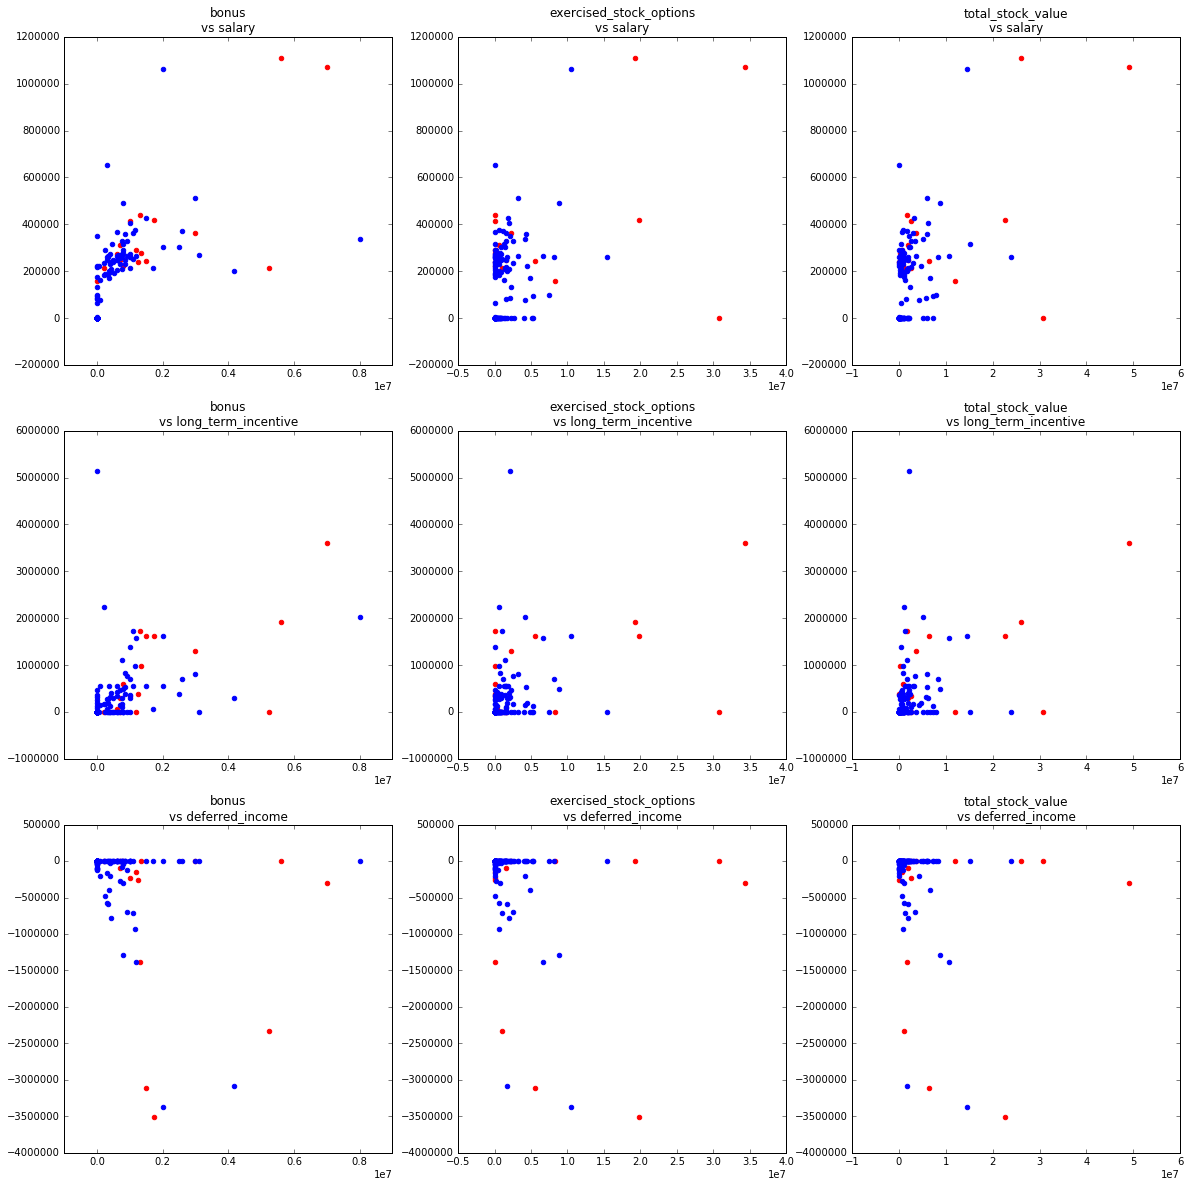

In [216]:
%matplotlib inline
### 15 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(3, 3)

### Set up the data
data = featureFormat(data_dict_new, total_features_list)

### Set the poi index
poi_ind = total_features_list.index('poi')

### the scatter plots of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_scatter_plot(x, y, r, c):
    ### Find index of x and y
    x_ind = total_features_list.index(x)
    y_ind = total_features_list.index(y)
    
    ### Create arrays for salary and bonus for poi and non-poi
    x_poi    = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    y_poi    = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    x_nonpoi = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
    y_nonpoi = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

    ### Draw Salary histogram
    axarr[r,c].scatter(x_poi,   y_poi,   color="r",label="poi")
    axarr[r,c].scatter(x_nonpoi,y_nonpoi,color="b",label="non-poi")
    axarr[r,c].set_title("{}\nvs {}".format(x,y))
    
### Setting x coordinate values and y coordinate values
x_values = ["bonus", "exercised_stock_options", "total_stock_value"]
y_values = ["salary", "long_term_incentive", "deferred_income"]

r = 0
c = 0
for y in y_values:
    for x in x_values: 
        subplot_scatter_plot(x,y,r,c)
        c = (c+1) % 3
    r += 1

plt.show()

Red dots are POIs and blue dots are non-POIs. I am not interested in identifying 4 POIs outside of the cluster at the left bottom corner because that can be identified very easily when I set a boundary between the cluster and outliners. What I am interested in is identifying POIs within the cluster. So I need to look for the scatter plot where red dots are close together within the cluster. A good example is a scatter plot between bonus and expense. POIs are close together and the cluster is more dispersed than other scatter plots. Another good example is scatter plot between bonus and long_term_incentive. 6 red dots are very close within the cluster.

### Creating a new feature

Based on the above plots, the blue dots have greater slopes than the red dots in the scatter plot of **exercised_stock_options** and **deferred_income**. I decided to create a new feature by dividing **deferred_income** from **exercised_stock_options** weighted by the sum of the squares of these features to the power of 0.2. I used the power of 0.2 to get a better distribution.

In [218]:
### Rescale each feature
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

features_list = total_features_list

### deferred_income
deferred_income = data[:,features_list.index("deferred_income")]
deferred_income = min_max_scaler.fit_transform(deferred_income) 

### exercised_stock_options
exercised_stock_options = data[:,features_list.index("exercised_stock_options")]
exercised_stock_options = min_max_scaler.fit_transform(exercised_stock_options) 

print np.min(deferred_income) 
print np.min(exercised_stock_options) 

### Creating a new feature - eso_expenses
tmp_array = np.empty([len(data[:,0]),1])
for i in range(len(data[:,0])):
    di = deferred_income[i]
    eso = exercised_stock_options[i]
    
    ### If both values are zero then set it 0
    if di * eso == 0:
        tmp_array[i,0] = 0
    else:
        tmp_array[i,0] = np.power(eso / di, .2) * np.power(di*di + eso*eso, .5)
#     tmp_array[i,0] = eso / ex * (ex*ex + eso*eso)
        
### Print out the original size of data
print "Before append:", data.shape

### Find max and min of the new feature
new_feature_max = np.max(tmp_array)
new_feature_min = np.min(tmp_array)

print "Max:", new_feature_max
print "Min:", new_feature_min


### Append the new feature column to data numpy array
if len(data[0,:]) == 8:
    ### To prevent appending a column again when rerunning the code
    data = np.delete(data, 7, axis = 1)

data = np.append(data, tmp_array, axis= 1)

### Print out the size of appended data
print "After append:", data.shape

### Add new feature to features_list
if features_list[-1] != "eso_deferred_income":
    features_list.append("eso_deferred_income")
    
print features_list

0.0
0.0
Before append: (144L, 19L)
Max: 1.37950509098
Min: 0.0
After append: (144L, 20L)
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'poi', 'eso_deferred_income']


C:\Users\wlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\wlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\wlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape 

The code above appends the new feature to the existing data numpy array. In the code I set the new feature's value equal to 0 when the denominator is zero or the numerator is zero to avoid having *inf* values.

Then I scaled the new feature to 0 to 1.

### Plotting a new feature

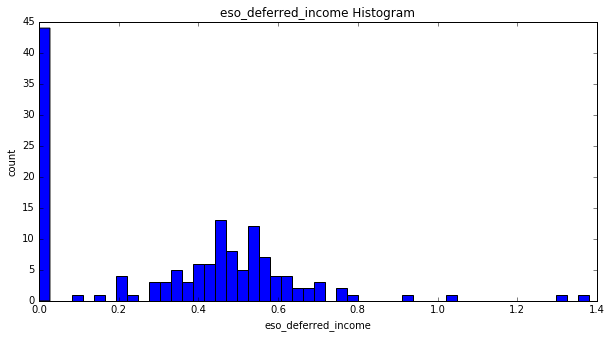

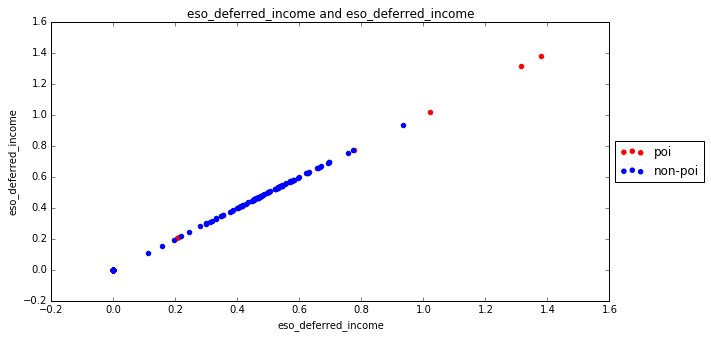

In [219]:
### Draw eso_expenses histogram
plt.rcParams["figure.figsize"] = (10,5)
plt.hist(data[:,features_list.index("eso_deferred_income")], bins=50)
plt.xlabel("eso_deferred_income")
plt.ylabel("count")
plt.title("eso_deferred_income Histogram")
plt.show()

### Scatter plot between bonus and total_stock_value
scatter_plotting("eso_deferred_income","eso_deferred_income")

The histogram shows that the majority of values of the new features are zeros. The second scatter plot is showing the distribution of the new feature colored by poi and non-poi.

## Testing the new feature - Decision Tree

I will run Decision Tree with this new feature and other features.

In [220]:
### Setting features array and label array
data_features_only = np.delete(data, features_list.index("poi"), 1)
labels = data[:, features_list.index("poi")]

### Take out poi from the features list
features_list_wo_poi = [i for i in features_list if i != "poi"]

### Rescale features
min_max_scaler = MinMaxScaler()
data_features_only = min_max_scaler.fit_transform(data_features_only) 

### Set the classifier
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_split=5)

### Use Stratified Shuffle Split for cross validation
from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)

### Format the result
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

Above codes are setting up what's necessary to run Decision Tree. Major of them are identical to the codes in **tester.py** file.

First of all, features and labels arrays are created and rescaled with **MinMaxScaler**.

Decision Tree with the best parameters are set up and for the cross validation, I am going to use **StratifiedShuffleSplit**. Since there are only 18 POIs, when using test and train split, the test data most likely would end up having no POIs. So folding the number of data will fix such problem.

In [221]:
### Calculate scores
def calculate_with_clf(clf):
    other_feature = [i for i in features_list_wo_poi if i != "eso_deferred_income"]
    for fe in other_feature:    
        print "eso_deferred_income and", fe
        features = data_features_only[:, [features_list_wo_poi.index("eso_deferred_income"), features_list_wo_poi.index(fe)]]

        true_negatives = 0
        false_negatives = 0
        true_positives = 0
        false_positives = 0

        ### Getting train and test data sets
        for train_idx, test_idx in cv: 
            features_train = []
            features_test  = []
            labels_train   = []
            labels_test    = []
            for ii in train_idx:
                features_train.append( features[ii] )
                labels_train.append( labels[ii] )
            for jj in test_idx:
                features_test.append( features[jj] )
                labels_test.append( labels[jj] )

                features_test.append( features[jj])
                labels_test.append( labels[jj] ) 


            ### fit the classifier using training set, and test on test set
            clf.fit(features_train, labels_train)
            try:
                print clf.best_params_
                for k,v in clf.best_params_.iteritems():
                    if k in best_params_collector:
                        best_params_collector[k].append(v)
                    else:
                        best_params_collector[k] = [v]
            except:
                pass

            predictions = clf.predict(features_test)
            for prediction, truth in zip(predictions, labels_test):
                ### Assign prediction either 0 or 1
                if prediction < .5:
                    prediction = 0
                else:
                    prediction = 1

                if prediction == 0 and truth == 0:
                    true_negatives += 1
                elif prediction == 0 and truth == 1:
                    false_negatives += 1
                elif prediction == 1 and truth == 0:
                    false_positives += 1
                elif prediction == 1 and truth == 1:
                    true_positives += 1

        try:
            total_predictions = true_negatives + false_negatives + false_positives + true_positives
            accuracy = 1.0*(true_positives + true_negatives)/total_predictions
            precision = 1.0*true_positives/(true_positives+false_positives)
            recall = 1.0*true_positives/(true_positives+false_negatives)
            f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
            f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
            print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
            print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
            print ""

        except:
            print "Got a divide by zero when trying out:", clf
            print "Precision or recall may be undefined due to a lack of true positive predicitons.\n"

In [222]:
calculate_with_clf(clf)

eso_deferred_income and salary
	Accuracy: 0.85213	Precision: 0.40302	Recall: 0.22650	F1: 0.29001	F2: 0.24825
	Total predictions: 30000	True positives:  906	False positives: 1342	False negatives: 3094	True negatives: 24658

eso_deferred_income and to_messages
	Accuracy: 0.86207	Precision: 0.46403	Recall: 0.22250	F1: 0.30078	F2: 0.24835
	Total predictions: 30000	True positives:  890	False positives: 1028	False negatives: 3110	True negatives: 24972

eso_deferred_income and deferral_payments
	Accuracy: 0.86107	Precision: 0.42308	Recall: 0.11550	F1: 0.18146	F2: 0.13515
	Total predictions: 30000	True positives:  462	False positives:  630	False negatives: 3538	True negatives: 25370

eso_deferred_income and total_payments
	Accuracy: 0.84860	Precision: 0.37715	Recall: 0.20800	F1: 0.26813	F2: 0.22850
	Total predictions: 30000	True positives:  832	False positives: 1374	False negatives: 3168	True negatives: 24626

eso_deferred_income and exercised_stock_options
	Accuracy: 0.87240	Precision: 0.5686

One noticiable result is eso_deferred_income and bonus.

**eso_deferred_income and bonus**

- Accuracy: ~ 86.1 %
- Precision: ~ 52.0 %
- Recall: ~ 34.3 %

The result is almost similar to the best scores from **bonus** and **exercised_stock_options**.

## Testing the new feature - KNN

This time I will calculate the new feature using **KNN** classifier.

In [223]:
### Set the classifier
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='auto')

Everything is the same. I just need to update **clf**. I used the best parameters that I got from **GridSearchCV**.

In [224]:
calculate_with_clf(clf)

eso_deferred_income and salary
	Accuracy: 0.85533	Precision: 0.39709	Recall: 0.16400	F1: 0.23213	F2: 0.18581
	Total predictions: 30000	True positives:  656	False positives:  996	False negatives: 3344	True negatives: 25004

eso_deferred_income and to_messages
	Accuracy: 0.88107	Precision: 0.63776	Recall: 0.25000	F1: 0.35920	F2: 0.28461
	Total predictions: 30000	True positives: 1000	False positives:  568	False negatives: 3000	True negatives: 25432

eso_deferred_income and deferral_payments
	Accuracy: 0.86167	Precision: 0.43633	Recall: 0.12850	F1: 0.19853	F2: 0.14961
	Total predictions: 30000	True positives:  514	False positives:  664	False negatives: 3486	True negatives: 25336

eso_deferred_income and total_payments
	Accuracy: 0.87920	Precision: 0.58468	Recall: 0.32450	F1: 0.41736	F2: 0.35620
	Total predictions: 30000	True positives: 1298	False positives:  922	False negatives: 2702	True negatives: 25078

eso_deferred_income and exercised_stock_options
	Accuracy: 0.86407	Precision: 0.4643

I got very nice result. Look at **eso_deferred_income** and **bonus** again.

- Accuracy: ~ 88.0%
- Precision: ~ 64.8%
- Recall: ~ 34.2%

Precision is very high which means if the algorithm says 100 people are POIs then there will be about 65 true POIs and 35 of them won't be POIs. This is the **best** result I got so far.

# Multivariate Analysis

This will be the final round of achieving the highest scores from the data set. So far I conducted a univariate analysis to find the single features having the highest scores and then through the bivariate analysis I found the pair of combinataions showing the best result for accuracy, precision and recall.

And I created a new feature based on my observations from the analysis and the new feature showed good scores.

I will run **Decision Tree** and **KNN** on these features including the new one and check the scores. I am not 100% certain that the scores will be better than the grades I've seen so far. For example, when you look at the pair of bonus and expense it shows the highest recall but shows very low accuracy and precision.

And I will use **GridSearchCV** instead of using the best parameters because the best parameters I chose are based on the bivariate analysis and they won't be suitable if they are used with more than 2 features. I will find the best parameters for multivariate.

## Decision Tree

I will set up the function that will calculate the scores with all the features with the chosen clf.

In [225]:
def calculate_all(clf):
    features = data_features_only
    
    best_params_collector = {}
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    ### Getting train and test data sets
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

            features_test.append( features[jj])
            labels_test.append( labels[jj] ) 


        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        
        try:
#             print clf.best_params_
            for k,v in clf.best_params_.iteritems():
                if k in best_params_collector:
                    best_params_collector[k].append(v)
                else:
                    best_params_collector[k] = [v]
        except:
            pass

        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            ### Assign prediction either 0 or 1
            if prediction < .5:
                prediction = 0
            else:
                prediction = 1

            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1

    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""

    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons.\n"
    
    return best_params_collector

Now I will use **Decision Tree** as clf.

In [226]:
### Set the classifier

clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_split=7)

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'splitter' : ['best', 'random'],
#     'min_samples_split': range(2,10)
#       }
# clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring='f1')

# Result
# {2: 115, 3: 111, 4: 121, 5: 132, 6: 144, 7: 129, 8: 149, 9: 99}
# {'random': 805, 'best': 195}
# {'gini': 542, 'entropy': 458}

In [227]:
result = calculate_all(clf)

	Accuracy: 0.83507	Precision: 0.35636	Recall: 0.29400	F1: 0.32219	F2: 0.30466
	Total predictions: 30000	True positives: 1176	False positives: 2124	False negatives: 2824	True negatives: 23876



The result is not as good as I expected. The overall scores are lower than the best scores from the bivariate analysis.

## KNN

In [228]:
clf = KNeighborsRegressor(n_neighbors=4, weights='uniform', algorithm='auto')

# param_grid = {
#     'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto','ball_tree','kd_tree','brute']
# }
# clf = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='average_precision') #average_precision

# {1: 67, 2: 59, 3: 125, 4: 177, 5: 108, 6: 69, 7: 74, 8: 95, 9: 105, 10: 121}
# {'distance': 49, 'uniform': 951}
# {'auto': 1000}

In [229]:
result = calculate_all(clf)

	Accuracy: 0.86387	Precision: 0.48562	Recall: 0.35450	F1: 0.40983	F2: 0.37474
	Total predictions: 30000	True positives: 1418	False positives: 1502	False negatives: 2582	True negatives: 24498



So the result is not as good as the one we saw before. Similar to the result of **Decision Tree**, although the values are not very bad, they are not the best one. This tells us that having more features in the model doesn't necessarily guarantee better scores.

I will use **bonus** and **eso_deferred_income** with **KNN** classifier as my final choice of combination for identifying POIs. The accuracy, precision and recall are all above 0.3.

# Final Thought

#### Usage of Evaluation Metrics

When evaluating the results, I calculated **Accuracy**, **Precision**, and **Recall**. I didn't put much emphasis on **Accuracy**. **Accuracy** is calculated by summing true positives and true negatives and dividing it by total predictions. Most of the time this value is above **70%**. Due to very small amount of POIs, assuming everything to be non-POI can give us a good **Accuracy**. So this score is not very reliable in deciding the best algorithm.

So I focus on using **Precision** and **Recall**. A good **Precision** tells you that when the algorithm identify POI groups from the test set, then most of them will be true POIs. A good **Recall** values tells you that most of the true POIs in the test set will be identified as POIs by the algorithm. I thought that both of these scores are equally important when choosing the best algorithm.

#### Discuss validation and its importance.

Validation is important when evaluating the algorithms. The most basic validation is Test and Train split with certain percentage. For example, if I use 70% then I take 70% of the data as a train set and 30% of the data as a test set. The algorithm is trained by the 70% of the data and it will be applied to the 30% and the result will be analyzed.

Test and Train is just one of many validations. Analyzing the algorithms using validations is very important because if we create an algorithm then we need to know if the algorithm really works before we apply this algorithm to the real world. Using the existing data set we have, we can estimate and predict what would happend if the algorithm is used in the real world. 

We need to choose the validation properly because sometimes depending on the data set we have, certain types of validations won't work very well. For example, in this project, using Train and Test validation won't provide us a reliable result because when dividing the data set into train and test, with a high probability, the test set won't contain any POIs, due to a small number of POI in the data set.

#### Validation Strategy

I used **StratifiedShuffleSplit** as a cross validation for this project. I thought this is the best cross validation to be used because it increases the size of the data points randomly and provides the better calculation. Due to small number of POIs in the data set, Test and Train split can cause zero POI in test set very frequently, so it won’t give very good calculation.

#### Further Note

For this final project, I first investigated the overall data set first. I checked the number features in the data set, the number of POIs, and see if there are any features with too many zeros or missing values. Then, I found an outlier and realized that there was “Total” summing all the features in the data set. I got rid of this “Total” and the data showed better plots. 


** Note: ** 
*poi_id.py* includes the result with the best scores from my investigation and it can be tested by running *tester.py*.

 